In [1]:
import cv2 as cv
import numpy as np
from os import walk
import matplotlib.pyplot as plt

%matplotlib inline
figsize = (15,22)

def _plot(img):
    plt.figure(figsize=figsize)
    plt.imshow(img)

## Template Matching

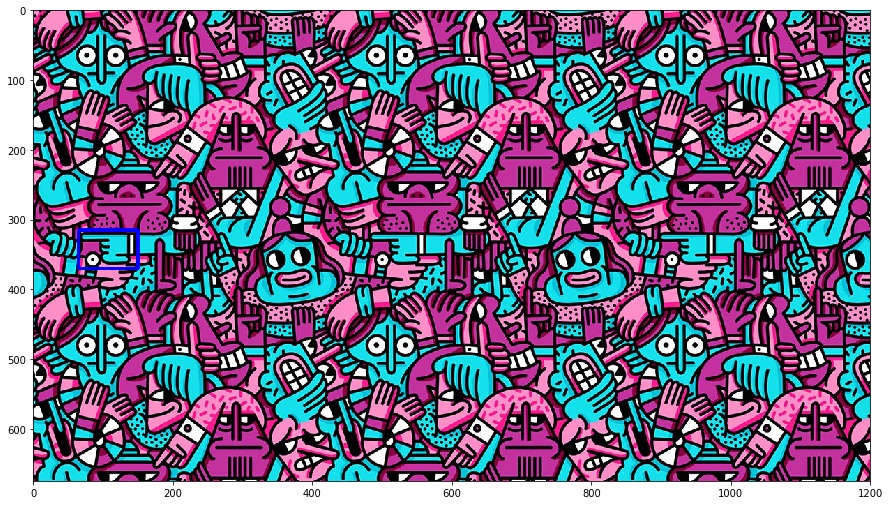

In [24]:
img = cv.imread('data/mess.jpg', cv.IMREAD_COLOR)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img2 = img.copy()
r1,r2,c1,c2 = 315,370,65,150
template = img2[r1:r2, c1:c2].copy()

cv.rectangle(img2, (c1,r1), (c2,r2), (0,0,255), 3)

_plot(img2)

In [2]:
def _normalize(x):
    xmax, xmin = x.max(), x.min()
    return (x - xmin)/(xmax - xmin)

def _threshold(mtr, th, method):
    x = _normalize(mtr)
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        x = 1 - x
        
    return np.where(x >= th)

In [20]:
# skeleton taken from https://docs.opencv.org/trunk/d4/dc6/tutorial_py_template_matching.html
def match(img, template, method_str):
    template = cv.cvtColor(template, cv.COLOR_RGB2GRAY)
    I = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    
    w, h = template.shape[::-1]
    method = eval(method_str)
    
    res = cv.matchTemplate(I, template, method)
    loc = _threshold(res, th=0.8, method=method)
        
    I = img.copy()
    for pt in zip(*loc[::-1]):
        cv.rectangle(I, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
    
    _plot(I)
    return

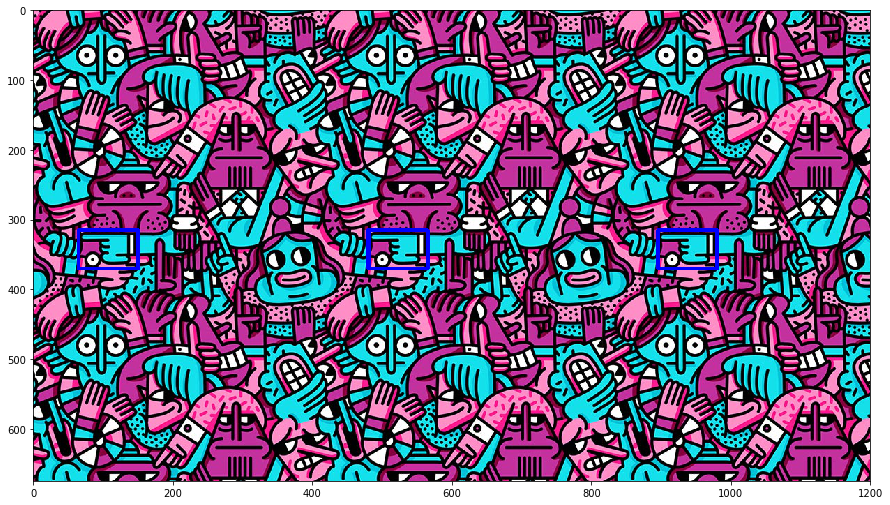

In [21]:
match(img, template, 'cv.TM_CCORR_NORMED')

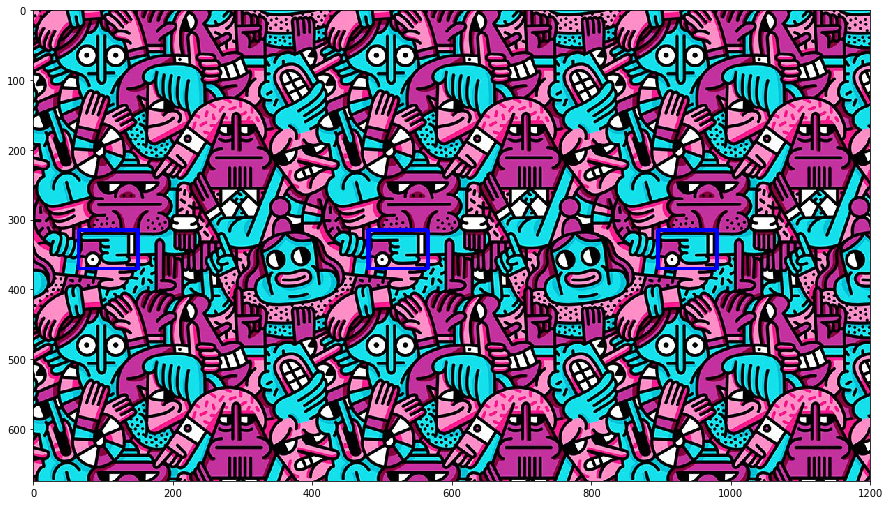

In [22]:
match(img, template, 'cv.TM_SQDIFF')

## Lucas-Kanade algorithm

In [7]:
# skeleton taken from https://docs.opencv.org/3.3.1/d7/d8b/tutorial_py_lucas_kanade.html
def LucasKanade(path, maxCorners, maxLevel=0, waitTime=240):
    frame_coll = []
    for (dirpath, dirnames, filenames) in walk(path + 'img/'):
        for f in filenames:
            file_path = dirpath + f
            img = cv.imread(file_path, cv.IMREAD_COLOR)
            frame_coll.append(img)
    
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = maxCorners,
                           qualityLevel = 0.3,
                           minDistance = 7,
                           blockSize = 7)
    
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                      maxLevel = maxLevel,
                      criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
    
    # Create some random colors
    color = np.random.randint(0, 255, (maxCorners,3))
    # Take first frame and find corners in it
    old_frame = frame_coll[0]
    old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
    p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    # Create a mask image for drawing purposes
    mask = img = np.zeros_like(old_frame)
    
    for i in range(1, len(frame_coll)):
        frame = frame_coll[i].copy()
        frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        # calculate optical flow
        p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]
        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv.line(mask, (a,b), (c,d), color[i].tolist(), 2)
            frame = cv.circle(frame, (a,b), 5, color[i].tolist(), -1)
            
        img = cv.add(frame, mask)
        cv.imshow('frame', img)
        k = cv.waitKey(waitTime) & 0xff
        if k == 27:
            break
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)
    
    _plot(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    cv.destroyAllWindows()

In the algorithm used below, we will use the Lucas-Kanade algorithm for motion tracking. The idea here is simple if we assume that between 2 frames intensity of an image doesn't change and that pixels generally moves in some patches rather than independently. That is, if some pixel on an image changed its location, we expect pixels from some neighborhood to change it as well. The second assumption is legit pixel doesn't represent a real-life entity. But real objects, which can be in motion, is represented with a collection of connected pixels

So back to the algorithm. As we can see, one of the parameters to our wrapper is `maxCorners`, which is passed to `goodFeaturesToTrack` function. It will return `maxCorners` strongest corners from an image discovered classically (identifying corners with some kernel, non-max suppression, select the strongest corner from the close neighborhood, return an array of corners sorter by their eigenvalues). That is because the edge is easier to track than some generic patch.

Then we also have the parameter `maxLevel` which is passed to `calcOpticalFlowPyrLK` function. It represents the number of pyramid levels. That is, Lucas-Canade algorithm of optical flow tracking works only with some small motions and fails to track a bigger one. To solve this issue, level processing was introduced. That is, $I_0$ is our 0-level image in the pyramid, which coincides with our initial image $I$. Then the following layers will be calculated recursively based on previous layers. That is, image $I_1$ will be the result of $I_0$ convolution with 3x3 gaussian kernel and stride=2. In this way, on higher levels we will have higher-level representation of an image, and thus small pixel motions will disappear there, and big motions will become small, which the algorithm can handle. Then optical flow from higher-level layer is passed recursively to a smaller layer as initial guess of pixel motion, which can help us to track any kind of movement. More details in [this paper][1] 

 [1]: http://robots.stanford.edu/cs223b04/algo_tracking.pdf

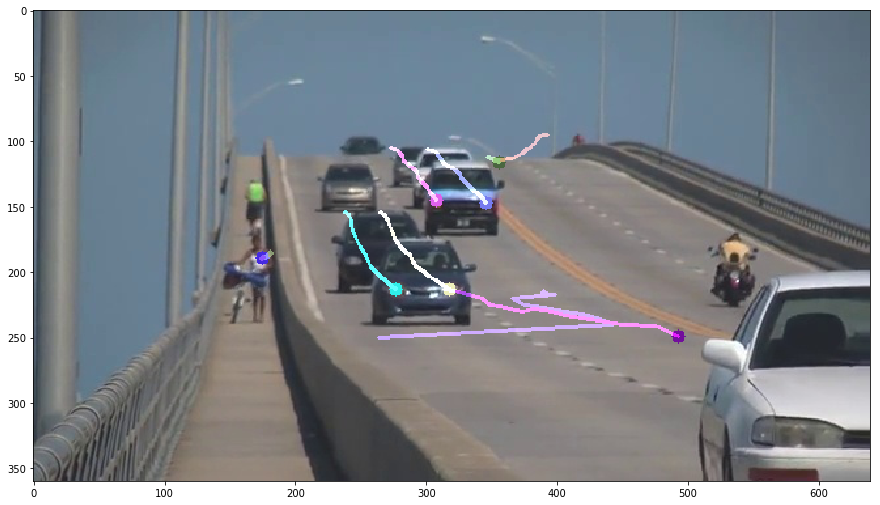

In [17]:
LucasKanade(path='data/CarOpenCV/', maxCorners=10, maxLevel=0)

As we can see on demo above, tracking algorithm works here pretty good, since objects are moving towards the camera and tracking points are mostly visible. Although, eventually some points get lost, probably due to higher movements at some point. We will try to fix it later with a pyramid approach described above.

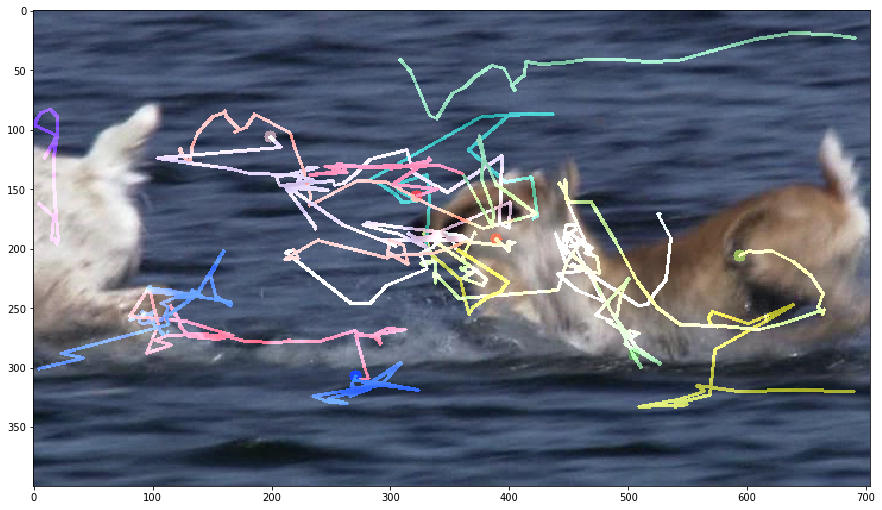

In [18]:
LucasKanade(path='data/Deer/', maxCorners=5, maxLevel=0)

Here tracking gets even worse since movement is move rapid and random. Also, a lot of points get lost since initial tracking patch dissappears from the image or moves too fast. Let's check how tracking will work on above 2 examples with a help of pyramid levels

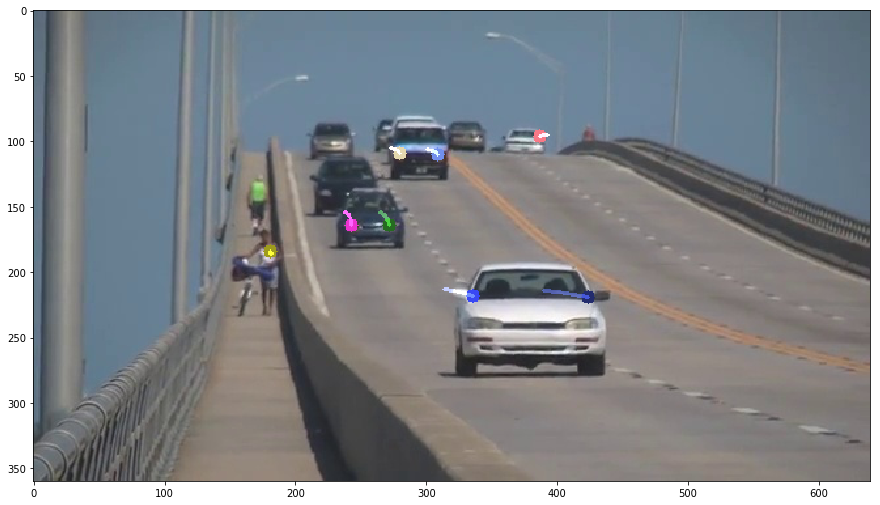

In [23]:
LucasKanade(path='data/CarOpenCV/', maxCorners=10, maxLevel=2)

And we get a significant improvement on simle demo with stable car movement. Now every point is correctly tracked during the entire clip.

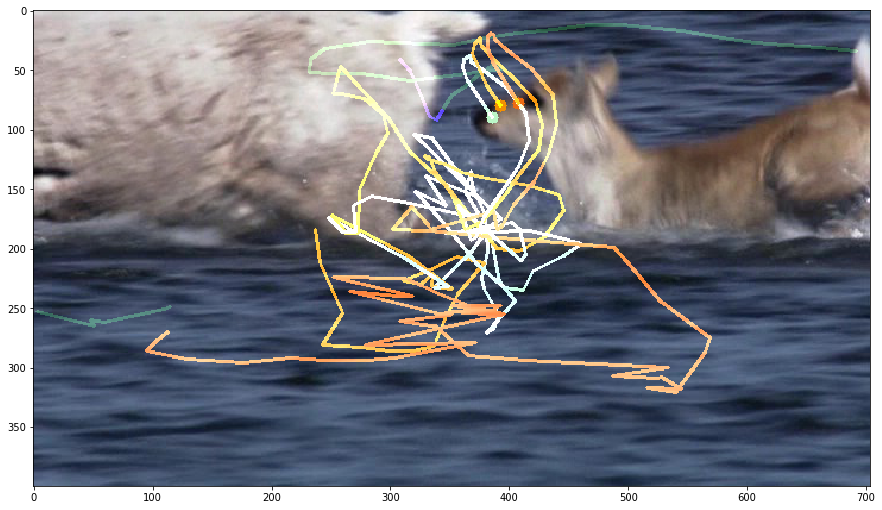

In [31]:
LucasKanade(path='data/Deer/', maxCorners=5, maxLevel=3, waitTime=120)

We have a significant improvement for deer demo as well. Algough, it's far from ideal since points still gets lost and then start tracking another patches.

But there are also improvements to algorithm which allows to fix that. That is, if object dissappears from the camera we want to remove the tracking point, not to pick another patch and continue tracking. To do so, every e.g. 5 iterations we make a template matching between all 5 frames. And if at some point similiarity drops significantly, it means that we've lost the object on that frame and thus need to remove the tracking point as well.

Let also check some additional examples of tracking:

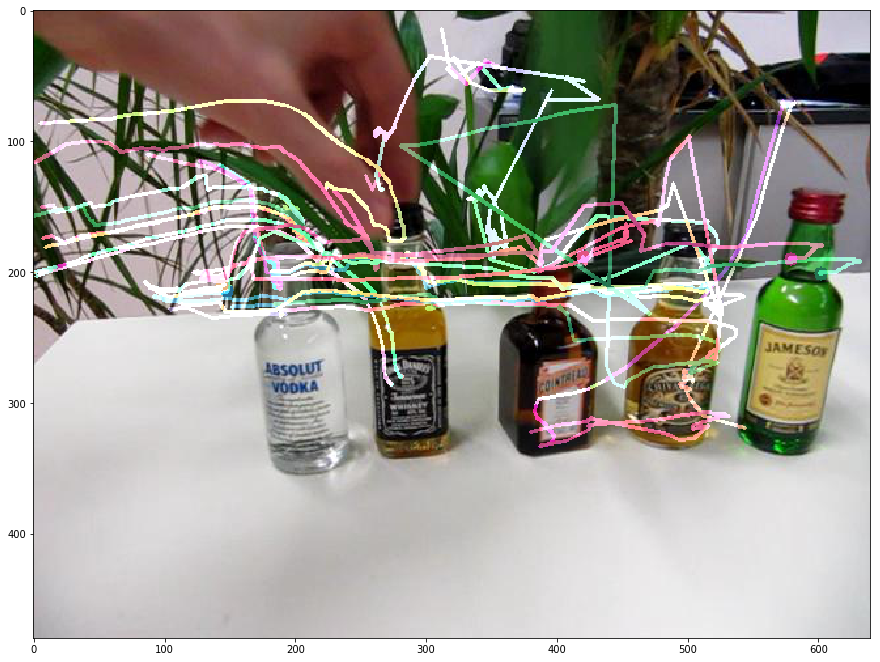

In [32]:
LucasKanade(path='data/Liquor/', maxCorners=20, maxLevel=3, waitTime=60)

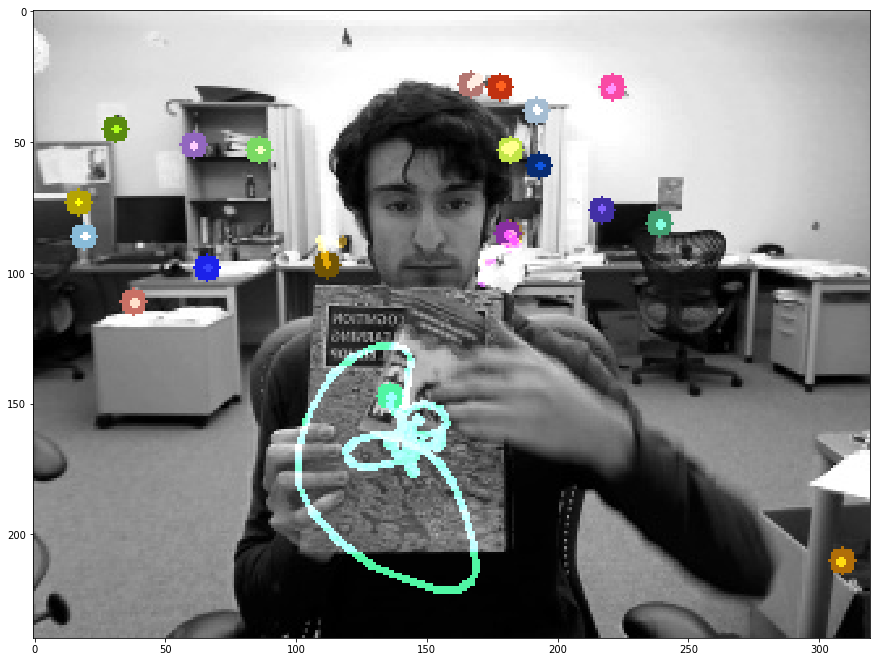

In [33]:
LucasKanade(path='data/ClifBar/', maxCorners=20, maxLevel=3, waitTime=120)